In [1]:
import sys
sys.path.append("./scripts")

from functions_basic import *
from numpy.random import default_rng
import random
from collections import deque


In [46]:
class Animal:
    # should contain its genome and possibility of changing it - genome as the thing that's causing the change
    def __init__(self, age, genome):
        self.age = age
        self.genome = genome
    
    def survival(self, kill_factors):
        # check if the Animal is going to survive this turn - this depends on killing factors from the world + probably age
        
        def sigmoid(x): return 1/(1 + np.exp(-x))

        probabilities = sigmoid(np.array(kill_factors) - np.array(self.genome.genes))
        rng = default_rng()
        
        return max(probabilities) < rng.uniform()
        
    
    def mutate(self):
        # allow for a slight chance for mutations during its life + also including destruction of genes? (maybe later)
        self.genome.genes = self.genome.genes + 0.1* np.random.uniform(-1, 1, size=len(self.genome.genes))
        pass
    

class Genome:
    # should contain genes
    def __init__(self, genes: list):
        self.genes = genes
    

class World:
    # should contain all animals and allow for their procreation 
    # + the world includes the killing factors which can change with time
    def __init__(self, animals, killing_factors):
        self.animals = animals
        self.killing_factors = killing_factors
        self.time = 0
    
    def procreate(self):
        for i in range(int(len(self.animals)/5)):
            chosen_animals = random.sample(self.animals, 2)
            rng = default_rng()
            new_genome = [a_genome if rng.uniform() > 0.5 else b_genome for i, (a_genome, b_genome) in enumerate(zip(chosen_animals[0].genome.genes, chosen_animals[1].genome.genes))]
            self.animals.append(Animal(0, Genome(new_genome)))
    
    def survival_check(self):
        alive_animals = []
        for animal in self.animals:
            if animal.survival(self.killing_factors):
                alive_animals.append(animal)
                
        self.animals = alive_animals
        
            
    def progress_time(self):
        self.time += 1
        for animal in self.animals:
            animal.age += 1
            animal.mutate()
        
        if self.time % 5== 0:
            self.survival_check()

        self.procreate()
        print(f"Current time: {self.time}")
        print(f"Number of alive animals: {len(self.animals)}")
#         return [animal.age for animal in self.animals], [animal.genome.genes for animal in self.animals]


In [47]:
rng = default_rng()
animals = [Animal(int(rng.uniform(0, 20)), Genome([rng.uniform() for i in range(2)])) for i in range(100)]
killing_factors = [-10, 0.2]
world = World(animals, killing_factors)

In [102]:
world.progress_time();

Current time: 55
Number of alive animals: 16615


In [105]:
genes = np.array([animal.genome.genes for animal in world.animals])
genes.transpose()[1]

array([1.40290139, 0.95650335, 1.71757285, ..., 1.26458511, 1.77761402,
       1.1119142 ])

(array([  12.,  102.,  561., 1864., 4185., 5091., 3453., 1129.,  204.,
          14.]),
 array([-0.61952351, -0.28208394,  0.05535564,  0.39279521,  0.73023478,
         1.06767436,  1.40511393,  1.74255351,  2.07999308,  2.41743265,
         2.75487223]),
 <BarContainer object of 10 artists>)

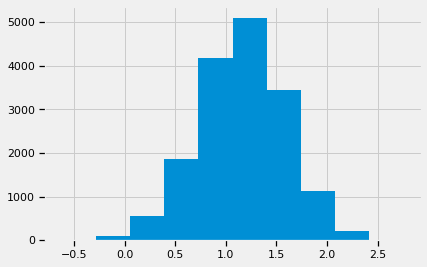

In [107]:
plt.hist(genes.transpose()[1])

(array([  10.,  308., 1303., 2941., 4172., 4115., 2498.,  934.,  276.,
          58.]),
 array([-1.17655467, -0.84481667, -0.51307867, -0.18134067,  0.15039733,
         0.48213533,  0.81387333,  1.14561133,  1.47734933,  1.80908733,
         2.14082533]),
 <BarContainer object of 10 artists>)

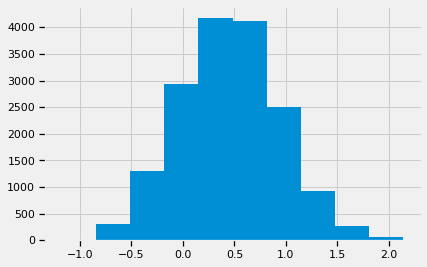

In [108]:
plt.hist(genes.transpose()[0])

In [ ]:
# Actually, I just need one array and one matrix to do the whole thing, then that can be analysed easily using statistics
# Recreate the above sim using numpy arrays.

In [6]:
world.animals[-1].genome.genes

[0.5176530735457227, 0.7422869577644416]

## Faster (hopefully) implementation using stack and matrices


In [221]:
from collections import deque

class World:
    def __init__(self, animal_alive: pd.Series, animal_age: pd.Series, animal_genes: pd.DataFrame, kill_factors: pd.Series):
        """
        animal_alive -> pd.Series with True for alive animals and False for dead animals
        animal_age -> pd.Series of integers starting from zero
        animal_genes -> DataFrame containing numerical values of genes w.r.t. kill_factors, each row is another animal
        kill_factors -> pd.Series of length equal to columns of animal_genes, 
                        describes numerical factors determining survivability of animals from the environment
        """
        self.animal_alive = animal_alive
        self.animal_age = animal_age
        self.animal_genes = animal_genes
        self.time = 0
        self.kill_factors = kill_factors
        self.animal_number = animal_alive.sum()
        self.max_pop = len(animal_alive)  # maximum length of the array
        
        # stack for tracking dead animals
        dead_stack = deque()
        dead_animals = animal_alive.apply(lambda x: not x)
        dead_animals = dead_animals[dead_animals].index.values  # since dead animals is a boolean array we can obtain index values
        for i in range(len(dead_animals)):
            dead_stack.append(dead_animals[-1-i])
        
        self.dead_stack = dead_stack
            
    def mutate(self):
        """
        Mutate genes of alive animals, use alive animals as a mask
        """
        print("mutate")
        gene_change = 0.1 * np.random.uniform(-1, 1, size=self.animal_genes.shape)
        mask = self.animal_alive.apply(int)
        self.animal_genes += (gene_change.T * mask.values).T  # adding change only to alive animals
        
        
    def survival(self):
        """
        Check for which animals are killed, update the dead_stack and alive animals
        """
        # algorithm for death from external factors
        print("calculate odds")
        odds = (self.kill_factors - self.animal_genes).sum(axis=1)
        
        MULT_FACTOR = 10
        def sigmoid(x): return 1/(1 + MULT_FACTOR*np.exp(-x))
        print("calculate probabilities")
        probabilities = sigmoid(odds)
        
        alive = np.random.uniform(0, 1, size=len(probabilities)) > probabilities
        mask = self.animal_alive.apply(int)
        alive = alive*mask  # converts dead from boolean to int
        
        # death from lack of food - depends on population size
        print("calculate food")
        survival_probability = 1 - self.animal_number / self.max_pop
        food_allowed = np.random.uniform(0, 1, size=self.max_pop) < survival_probability
        food_allowed = food_allowed*mask
        
        alive = np.logical_and(alive, food_allowed)
        
        # update the animal_alive and dead_stack - bookkeeping
        print("bookkeeping")
        new_dead = np.logical_xor(self.animal_alive, alive)
        print("line 1")
        self.animal_alive = alive
        print("line 2")
        self.animal_age = self.animal_age * alive.apply(int)
        print("line 3")
        self.animal_genes = (self.animal_genes.values.T * alive.apply(int).values).T
        print("line 4")
        
        print("New Dead")
        new_dead = new_dead[new_dead].index.values
        self.animal_number -= len(new_dead)
        print(f"{len(new_dead)} animals died this turn")
        
        print("dead_stack")
        for i in range(len(new_dead)):
            self.dead_stack.append(new_dead[-1-i])
        
        
    
    def procreate(self):
        """
        Create new animals out of mating of existing ones, update the dead_stack and alive animals
        """
        print("procreation")
        alive = self.animal_alive[self.animal_alive].index.values
        PROPORTION_MATING = 0.2
        new_animals_number = int(PROPORTION_MATING*len(alive))
        self.animal_number += new_animals_number
        
        print(f"{new_animals_number} animals were born this turn")
        
        for i in range(new_animals_number):
            chosen_animals = random.sample(alive, 2)
            a_genome, b_genome = self.animal_genes.iloc[chosen_animals[0], :], self.animal_genes.iloc[chosen_animal[1], :]
            
            new_genome = np.where(np.random.uniform(0, 1, size=len(a_genome)) > 0.5, a_genome, b_genome)
            
            # update the main matrix
            index = self.dead_stack.pop()
            self.animal_age[index] = 0
            self.animal_alive[index] = True
            self.animal_genes.iloc[index, :] = new_genome
    
    def statistics(self):
        pass
        
    def progress_time(self):
        self.time += 1
        print(f"Turn: {self.time}")
        self.animal_age += self.animal_alive.apply(int)
        print(f"Average animal age is {np.sum(self.animal_age) / self.animal_number}")
        
        self.mutate()
        self.survival()
        self.procreate()
        print(f"The total number of animals is {self.animal_number}")
        
        
        

In [222]:
max_pop = 50000
animal_alive = np.zeros(max_pop)
animal_alive[:500] = 1

animal_age = np.random.uniform(0, 40, size=max_pop)
animal_age = animal_age*animal_alive

animal_genes = np.random.uniform(0, 1, size=(max_pop, 2))
animal_genes = (animal_genes.T*animal_alive).T

animal_alive = pd.Series(animal_alive).apply(bool)
animal_age = pd.Series(animal_age).apply(int)
animal_genes = pd.DataFrame(animal_genes)

kill_factors = [-50, 0.2]

world = World(animal_alive, animal_age, animal_genes, kill_factors)

In [223]:
world.progress_time()

Turn: 1
Average animal age is 20.128
mutate
calculate odds
calculate probabilities
calculate food
bookkeeping
line 1
line 2
line 3
line 4
New Dead
6 animals died this turn
dead_stack
procreation
98 animals were born this turn


TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [209]:
a1 = world.animal_alive.apply(int)
a2 = world.animal_genes
a1, a2

(0    1
 1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 7    1
 8    1
 9    1
 dtype: int64,
           0         1
 0  0.872966  0.608066
 1  0.363364  0.920007
 2  0.564938  0.512111
 3  0.505930  0.231134
 4  0.692581  0.730125
 5  0.271621  0.369853
 6  0.264103  0.911529
 7  0.079577  0.654805
 8  0.369237  0.773160
 9  0.944684  0.619425)

In [210]:
a2 * a1

,0,1,2,3,4,5,6,7,8,9
0,0.872966,0.608066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.363364,0.920007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.564938,0.512111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.505930,0.231134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.692581,0.730125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.271621,0.369853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.264103,0.911529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.079577,0.654805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.369237,0.773160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.944684,0.619425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
animal_alive[500]

0.0

In [174]:
a3

,0,1,2
0,-0.9,-1.8,-2.9
1,1.0,0.0,1.0
2,-6.9,-7.8,-8.9
3,-9.9,-10.8,-11.9
